# Построение графиков загрузки по данным из сущпола

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-блокнота" data-toc-modified-id="Описание-блокнота-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание блокнота</a></span></li><li><span><a href="#Импортируемые-библиотеки" data-toc-modified-id="Импортируемые-библиотеки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Импортируемые библиотеки</a></span></li><li><span><a href="#Подключение-к-БД" data-toc-modified-id="Подключение-к-БД-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подключение к БД</a></span></li><li><span><a href="#Выгрузка-остановок" data-toc-modified-id="Выгрузка-остановок-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выгрузка остановок</a></span></li><li><span><a href="#Выгрузка-параметров-маршрутов" data-toc-modified-id="Выгрузка-параметров-маршрутов-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выгрузка параметров маршрутов</a></span></li><li><span><a href="#Функция-для-построения-графика" data-toc-modified-id="Функция-для-построения-графика-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Функция для построения графика</a></span></li><li><span><a href="#Построение-графика" data-toc-modified-id="Построение-графика-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Построение графика</a></span></li></ul></div>

## Описание блокнота

Блокнот выгружает сущпол графики загрузки по trip_id маршрута на основе DataFram'а `volume_by_route`.<br> 
Подготовлена функция со следующими параметрами:
- date: дата в формате "ГГММДД" - int,
- hour_1: час суток - int,
- hour_2: час суток - int,
- hour_3: час суток - int,
- trip_id: номер trip_id - int,
- num_vehicle: {'one', 'all'} - str:
    - one - загрузка рассчитывается для одного ТС по указанному trip_id,
    - all - загрузка рассчитывается дял всех ТС по указанному trip_id.
    
Блокнот создает папку volume_plot и сохраняет в нее графики.

## Импортируемые библиотеки

In [1]:
# импортируемые все необходимые модули / библиотеки 
import pandas as pd
import geopandas as gpd
import sqlalchemy
from sqlalchemy import create_engine
from tqdm import tqdm

from datetime import datetime
from datasets.processed.askp_passflows import get

import matplotlib.pyplot as plt
import math
from bokeh.plotting import figure, show
from bokeh.models import Legend,LegendItem
from bokeh.io import export_png
from tqdm.notebook import tqdm as tqdm

import os

import warnings
warnings.filterwarnings("ignore")

## Подключение к БД

In [2]:
db_config = {
'user' : '', # Логин
'pwd' : '', # Пароль
'host' : 'airms.mgtniip.ru', # Хост
'port' : 5432, # Порт подключения
'db' : 'UARMS' # Название базы данных
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'],
                                                        db_config['pwd'],
                                                        db_config['host'],
                                                        db_config['port'],
                                                        db_config['db'])

engine = create_engine(connection_string)

## Выгрузка остановок

In [3]:
query_stops = """
select stop_id, stop_name
from routes.stops()
order by stop_id
"""
stops_all = pd.read_sql(query_stops, con=engine)
stops_all.head(3)

,stop_id,stop_name
0,7,Дербеневская наб.
1,11,Набережная Тараса Шевченко
2,12,Наб. Тараса Шевченко


## Выгрузка параметров маршрутов

In [4]:
query_mvns = """
select * from routes.mvns ('2022-05-16', 1)
"""
mvns =  pd.read_sql(query_mvns, con=engine)
mvns.head(3)
# mvns[mvns['trip_id']==2000021]

,trip_id,mvn,route_id,route_name,route_long_name,transport_type,branch_ids,is_circle,date_gk_start,date_gk_end,...,direction,length_doc,length_graph,length_mgt,agency_name,agency_id,registry_type,registry_number,gk_number,commercial
0,433,251к-00-А-прямое,1075,251к,"Метро ""Молодежная"" - Рубежный пр.",А,115,False,2014-07-10,None,...,0,NaN,3.778,3.78387,ГУП «Мосгортранс»,0,муниципальный,287.0,None,False
1,434,251к-00-А-обратное,1075,251к,"Метро ""Молодежная"" - Рубежный пр.",А,115,False,2014-07-10,None,...,1,NaN,3.347,3.42601,ГУП «Мосгортранс»,0,муниципальный,287.0,None,False
2,661,49-00-А-прямое,582,49,"Метро ""Беляево"" - Санаторий ""Узкое""",А,120,False,2012-01-01,None,...,0,NaN,8.219,8.23701,ГУП «Мосгортранс»,0,муниципальный,58.0,None,False


## Функция для построения графика

In [5]:
def get_volume(date, hour_1, hour_2, hour_3, trip_id, num_vehicle):
    date = str(date)
    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:])
    volume_by_route = get(datetime(year,month,day),'volume_by_route')
    volume_by_route['hour'] = volume_by_route['timestamp'].dt.hour

    # Выбор данных для конкретного маршрутного варианта и часа суток
    volume_selected1 = volume_by_route[(volume_by_route['trip_id']==trip_id)&(volume_by_route['hour']==hour_1)].sort_values(
        by=['stop_sequence'])
    volume_selected2 = volume_by_route[(volume_by_route['trip_id']==trip_id)&(volume_by_route['hour']==hour_2)].sort_values(
        by=['stop_sequence'])
    volume_selected3 = volume_by_route[(volume_by_route['trip_id']==trip_id)&(volume_by_route['hour']==hour_3)].sort_values(
        by=['stop_sequence'])

    # Присоединяем колонку stop_name из таблицы с остановками
    final = volume_selected1.merge(stops_all[['stop_id','stop_name']], on = 'stop_id', how="left")
    final = final.merge(mvns[['route_id', 'trip_id', 'mvn', 'route_name']], on = ['route_id','trip_id'], how = 'left')   

    if num_vehicle == 'one':
        final['capacity'] = final['capacity']/final['num_of_trips']
        final['cnt_on'] = final['cnt_on']/final['num_of_trips']
        final['cnt_off'] = final['cnt_off']/final['num_of_trips']
        final['cnt_inside'] = final['cnt_inside']/final['num_of_trips']
        volume_selected2['cnt_inside'] = volume_selected2['cnt_inside']/volume_selected2['num_of_trips']
        volume_selected3['cnt_inside'] = volume_selected3['cnt_inside']/volume_selected3['num_of_trips']
    elif num_vehicle == 'all':
        next
    else:
        print('уточните для какого числа тс строится график')

    # Построение графика 
    final['idx'] = final.index
    sequence = list(final['stop_sequence'])
    cnt_inside = list(final['cnt_inside'])
    cnt_inside2 = list(volume_selected2['cnt_inside'])
    cnt_inside3 = list(volume_selected3['cnt_inside'])

    cnt_on = list(final['cnt_on'])
    cnt_off = list(final['cnt_off'])
    capacity = final['capacity']
    capacity1 = capacity[0]


    p = figure(plot_height=800, plot_width = 1300)

    r1 = p.vbar(x = [x-0.2 for x in range(len(final))], width=0.4, bottom=0, top=cnt_on, color = 'orange')
    r2 = p.vbar(x = [x+0.2 for x in range(len(final))], width=0.4, bottom=0, top=cnt_off, color = 'royalblue')

    r0 = p.line(x=list(final['idx']), y=cnt_inside, line_width=2, color='gray')
    r02 = p.line(x=list(final['idx']), y=cnt_inside2, line_width=2, color='blue')
    r03 = p.line(x=list(final['idx']), y=cnt_inside3, line_width=2, color='red')
    r3 = p.line(x=list(final['idx']), y=capacity1, line_width=2, color='red')

    legend = Legend(items=[
        ("Посадка_8"   , [r1]),
        ("Высадка_8" , [r2]),
        ("Наполнение_8" , [r0]),
        ("Наполнение_12" , [r02]),
        ("Наполнение_18" , [r03]),
        ("Провозная способность" , [r3])],location="center")
    p.add_layout(legend, 'right')

    ax_list = list(final.index)
    p.xaxis.ticker = ax_list
    p.xaxis.major_label_overrides = final.set_index('idx')['stop_name'].to_dict()
    p.xaxis.major_label_orientation = -math.pi/5

    p.xaxis.major_label_text_font_size = '8pt'
    p.xaxis.major_label_text_align = 'center'
    p.xaxis.major_label_text_font_style = 'bold'

    i = final['mvn']
    i = i[0]  
    
    plt.show(p)
    
    return export_png(p, filename="{}\{}.png".format(path_save, i))

## Построение графика

In [6]:
path_save = r'C:\Users\ovnanyan_gm\btb_matrix\notebooks\data\Графики загрузки\сущпол'
date = 20220516
hour_1 = 8
hour_2 = 12
hour_3 = 18
# trip_id_list = mvns['trip_id'].unique()
trip_id_list = [43379]
num_vehicle = 'one'

In [7]:
for trip_id in trip_id_list:
    try:
        get_volume(date, hour_1, hour_2, hour_3, trip_id, num_vehicle)
        print('Save:', trip_id)
        print('*'*20)
    except:
        print('error:', trip_id)
        print('*'*20)

Save: 43379
********************


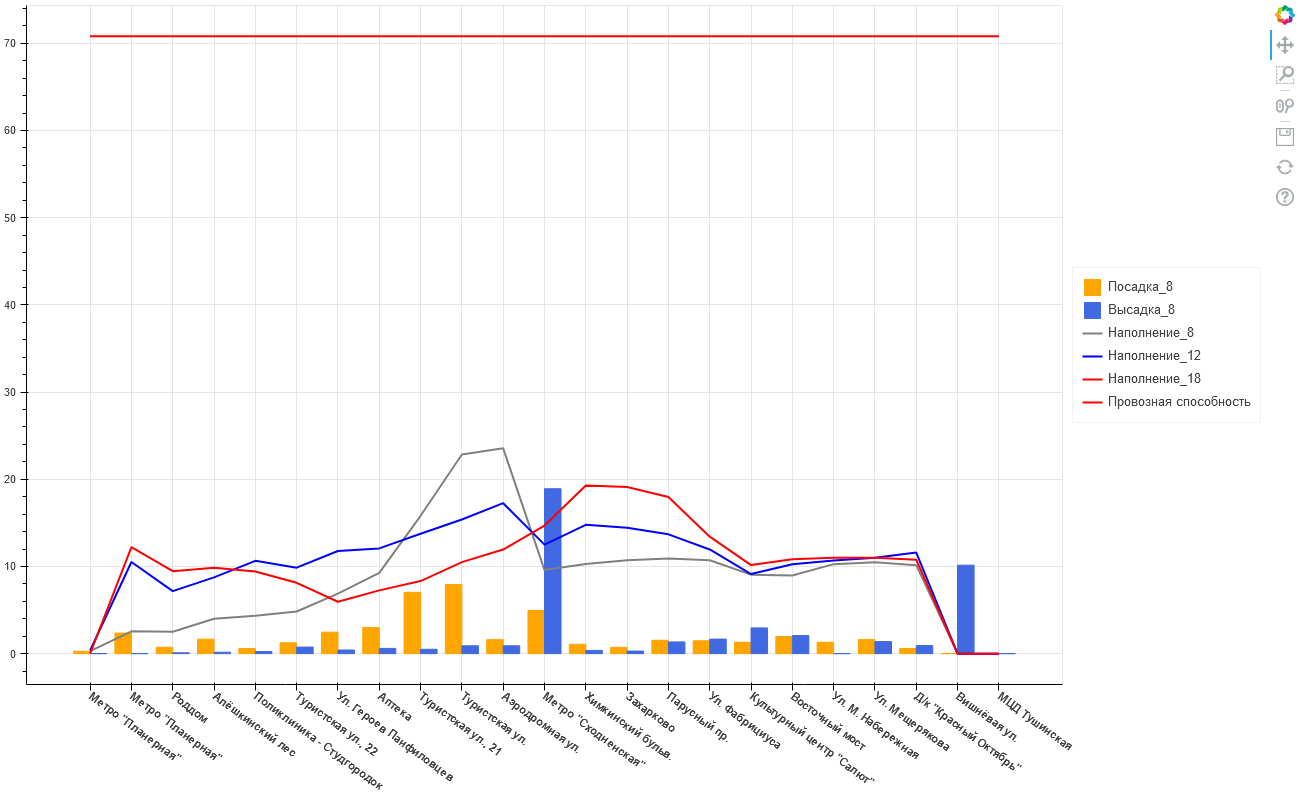

In [8]:
from PIL import Image
Image.open(r'C:\Users\ovnanyan_gm\btb_matrix\notebooks\data\Графики загрузки\сущпол\96-00-А-прямое.png')